<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/FinRL_PortfolioAllocation_NeurIPS_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Portfolio Allocation

Tutorials to use OpenAI DRL to perform portfolio allocation in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-portfolio-allocation-9b417660c7cd
* Please report any issues to our Github: https://github.com/AI4Finance-Foundation/FinRL/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for portfolio alloacation. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A represents the weight of a stock in the porfolio: a ∈ (-1,1). Assume our stock pool includes N stocks, we can use a list [a<sub>1</sub>, a<sub>2</sub>, ... , a<sub>N</sub>] to determine the weight for each stock in the porfotlio, where a<sub>i</sub> ∈ (-1,1), a<sub>1</sub>+ a<sub>2</sub>+...+a<sub>N</sub>=1. For example, "The weight of AAPL in the portfolio is 10%." is [0.1 , ...].

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys
sys.path.append("../FinRL-Library")

/Users/i0495036/Documents/sandbox/RL_factor_style_investing/.venv/lib/python3.11/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [6]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [14]:
dp = YahooFinanceProcessor()
df = dp.download_data(start_date = '2008-01-01',
                     end_date = '2021-10-31',
                     ticker_list = config_tickers.DOW_30_TICKER, time_interval='1D')

YF.download() has changed argument auto_adjust default to True


Failed to get ticker 'AXP' reason: HTTPSConnectionPool(host='fc.yahoo.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1006)')))
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AXP']: YFTzMissingError('possibly delisted; no timezone found')
Failed to get ticker 'AXP' reason: HTTPSConnectionPool(host='fc.yahoo.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1006)')))
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AXP']: YFTzMissingError('possibly delisted; no timezone found')
Failed to get ticker 'AXP' reason: HTTPSConnectionPool(host='fc.yahoo.com', port=443): Max retries exceede

KeyboardInterrupt: 

In [28]:
train = pd.read_csv('../datasets/train_data.csv',parse_dates=['date'])
trade = pd.read_csv('../datasets/trade_data.csv',parse_dates=['date'])
df = pd.concat([train,trade])
# keep only date	open	high	low	close	adjcp	volume	tic	day
df = df[['date','tic','open','high','low','close','volume']]

In [5]:
df.head()

date   tic       open       high        low      close       volume
0 2009-01-02  AAPL   3.067143   3.251429   3.041429   2.733997  746015200.0
1 2009-01-02  AMGN  58.590000  59.080002  57.750000  41.816166    6547900.0
2 2009-01-02   AXP  18.570000  19.520000  18.400000  14.978852   10955700.0
3 2009-01-02    BA  42.799999  45.560001  42.779999  33.941093    7010200.0
4 2009-01-02   CAT  44.910000  46.980000  44.709999  30.602575    7117200.0

In [3]:
df.shape

(116696, 7)

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [4]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [5]:
df.shape

(116696, 15)

In [7]:
df.head()

date   tic       open       high        low      close  \
0     2009-01-02  AAPL   3.067143   3.251429   3.041429   2.733997   
3397  2009-01-02  AMGN  58.590000  59.080002  57.750000  41.816166   
6794  2009-01-02   AXP  18.570000  19.520000  18.400000  14.978852   
10191 2009-01-02    BA  42.799999  45.560001  42.779999  33.941093   
13588 2009-01-02   CAT  44.910000  46.980000  44.709999  30.602575   

            volume  macd   boll_ub  boll_lb  rsi_30     cci_30  dx_30  \
0      746015200.0   0.0  2.954869  2.62851   100.0  66.666667  100.0   
3397     6547900.0   0.0  2.954869  2.62851   100.0  66.666667  100.0   
6794    10955700.0   0.0  2.954869  2.62851   100.0  66.666667  100.0   
10191    7010200.0   0.0  2.954869  2.62851   100.0  66.666667  100.0   
13588    7117200.0   0.0  2.954869  2.62851   100.0  66.666667  100.0   

       close_30_sma  close_60_sma  
0          2.733997      2.733997  
3397      41.816166     41.816166  
6794      14.978852     14.978852  
10191     33.941093     33.941093  
13588     30.602575     30.602575

## Add covariance matrix as states

In [6]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)
        

In [7]:
df.shape

(109388, 17)

In [10]:
df.head()

date   tic       open       high        low      close       volume  \
0 2010-01-04  AAPL   7.622500   7.660714   7.585000   6.447412  493729600.0   
1 2010-01-04  AMGN  56.630001  57.869999  56.560001  40.915890    5277400.0   
2 2010-01-04   AXP  40.810001  41.099998  40.389999  32.828987    6894300.0   
3 2010-01-04    BA  55.720001  56.389999  54.799999  43.777546    6186700.0   
4 2010-01-04   CAT  57.650002  59.189999  57.509998  39.883915    7325600.0   

       macd    boll_ub    boll_lb     rsi_30      cci_30      dx_30  \
0  0.118289   6.510970   5.543710  62.133205  168.772838  33.760635   
1  0.228505  41.353270  38.865132  52.849983   85.708926   6.350919   
2  0.288680  33.751086  31.445586  56.779308    1.010526  11.537387   
3  0.501040  44.009583  41.898205  58.805013   81.205370  10.840906   
4  0.075727  40.281288  38.378911  55.292778   49.368540   8.534279   

   close_30_sma  close_60_sma  \
0      6.031814      5.978972   
1     40.102820     40.027089   
2     32.716402     31.134857   
3     42.319077     40.753000   
4     39.489725     39.112555   

                                            cov_list  \
0  [[0.0004430600728517973, 0.0001369793550926741...   
1  [[0.0004430600728517973, 0.0001369793550926741...   
2  [[0.0004430600728517973, 0.0001369793550926741...   
3  [[0.0004430600728517973, 0.0001369793550926741...   
4  [[0.0004430600728517973, 0.0001369793550926741...   

                                         return_list  
0  tic             AAPL      AMGN       AXP      ...  
1  tic             AAPL      AMGN       AXP      ...  
2  tic             AAPL      AMGN       AXP      ...  
3  tic             AAPL      AMGN       AXP      ...  
4  tic             AAPL      AMGN       AXP      ...

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.


## Training data split: 2009-01-01 to 2020-07-01

In [8]:
train = data_split(df, '2009-01-01','2021-01-01')
val = data_split(df, '2021-01-01','2022-01-01')
trade = data_split(df,'2022-01-01', '2025-01-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)

In [9]:
train.head()

date   tic       open       high        low      close       volume  \
0 2010-01-04  AAPL   7.622500   7.660714   7.585000   6.447412  493729600.0   
0 2010-01-04  AMGN  56.630001  57.869999  56.560001  40.915890    5277400.0   
0 2010-01-04   AXP  40.810001  41.099998  40.389999  32.828987    6894300.0   
0 2010-01-04    BA  55.720001  56.389999  54.799999  43.777546    6186700.0   
0 2010-01-04   CAT  57.650002  59.189999  57.509998  39.883915    7325600.0   

       macd    boll_ub    boll_lb     rsi_30      cci_30      dx_30  \
0  0.118289   6.510970   5.543710  62.133205  168.772838  33.760635   
0  0.228505  41.353270  38.865132  52.849983   85.708926   6.350919   
0  0.288680  33.751086  31.445586  56.779308    1.010526  11.537387   
0  0.501040  44.009583  41.898205  58.805013   81.205370  10.840906   
0  0.075727  40.281288  38.378911  55.292778   49.368540   8.534279   

   close_30_sma  close_60_sma  \
0      6.031814      5.978972   
0     40.102820     40.027089   
0     32.716402     31.134857   
0     42.319077     40.753000   
0     39.489725     39.112555   

                                            cov_list  \
0  [[0.0004430600728517973, 0.0001369793550926741...   
0  [[0.0004430600728517973, 0.0001369793550926741...   
0  [[0.0004430600728517973, 0.0001369793550926741...   
0  [[0.0004430600728517973, 0.0001369793550926741...   
0  [[0.0004430600728517973, 0.0001369793550926741...   

                                         return_list  
0  tic             AAPL      AMGN       AXP      ...  
0  tic             AAPL      AMGN       AXP      ...  
0  tic             AAPL      AMGN       AXP      ...  
0  tic             AAPL      AMGN       AXP      ...  
0  tic             AAPL      AMGN       AXP      ...

## Environment for Portfolio Allocation


In [10]:
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv


In [11]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 29


In [12]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [13]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [14]:
e_eval_gym = StockPortfolioEnv(df=val,**env_kwargs)

In [15]:
env_eval, _ = e_eval_gym.get_sb_env()
print(type(env_eval))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [18]:
# initialize
agent = DRLAgent(env = env_train)

### Model 1: **A2C**


In [36]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS, tensorboard_log=config.TENSORBOARD_LOG_DIR)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [38]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000)

Logging to tensorboard_log/a2c_2
-------------------------------------
| time/                 |           |
|    fps                | 495       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -40       |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 10099     |
|    policy_loss        | 1.35e+08  |
|    reward             | 1281337.1 |
|    std                | 0.96      |
|    value_loss         | 1.63e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 570       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -40       |
|    explained_variance | 1.19e-07  |
|    learning_rat

In [42]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def list_scalars_in_log(log_dir):
    """Prints all available scalar names in the given TensorBoard log directory."""
    event_files = [f for f in os.listdir(log_dir) if "events.out.tfevents" in f]
    if not event_files:
        print(f"No TensorBoard event files found in {log_dir}")
        return

    event_file = os.path.join(log_dir, event_files[-1])
    event_acc = EventAccumulator(event_file)
    event_acc.Reload()
    
    print("Available scalars in logs:")
    print(event_acc.Tags()["scalars"])

# Replace with your log directory
list_scalars_in_log("./tensorboard_log/a2c_1")


Available scalars in logs:
['time/fps', 'train/entropy_loss', 'train/explained_variance', 'train/learning_rate', 'train/policy_loss', 'train/reward', 'train/std', 'train/value_loss']


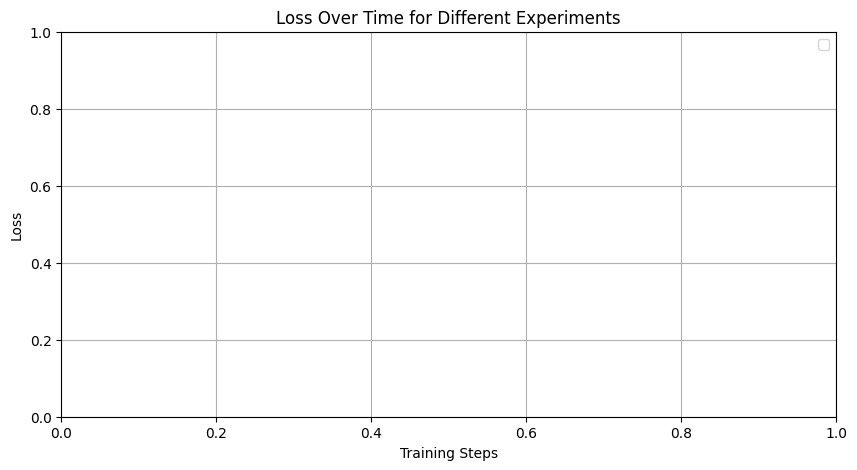

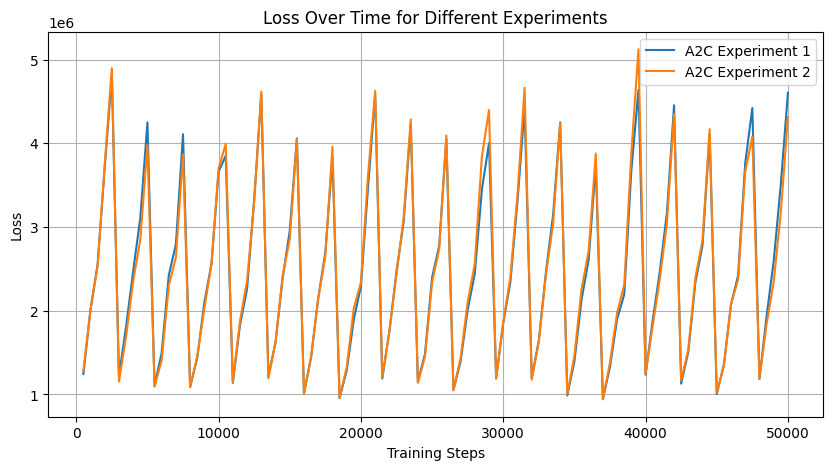

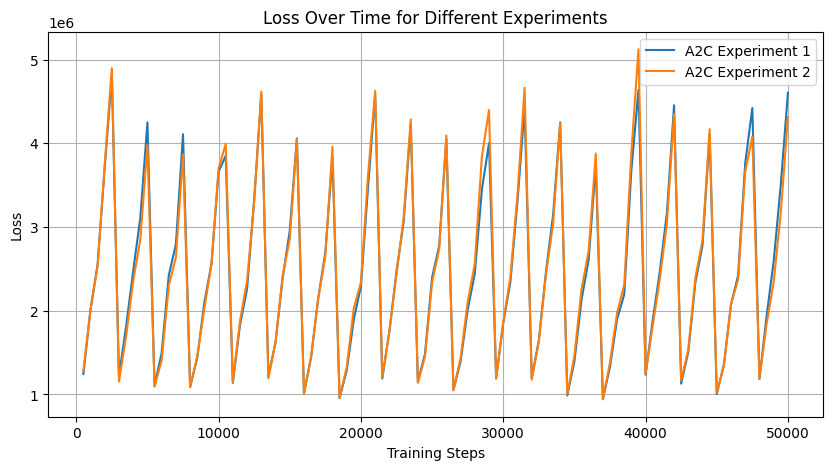

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def extract_scalar_from_event_file(log_dir, scalar_name="rollout/ep_rew_mean"):
    """
    Extracts scalar data (e.g., loss, rewards) from a TensorBoard log directory.

    Parameters:
        log_dir (str): Path to the TensorBoard log directory.
        scalar_name (str): The scalar to extract, e.g., "train/loss" or "rollout/ep_rew_mean".

    Returns:
        steps (list): The training steps (x-axis).
        values (list): The scalar values (y-axis).
    """
    event_files = [f for f in os.listdir(log_dir) if "events.out.tfevents" in f]
    if not event_files:
        print(f"No TensorBoard event files found in {log_dir}")
        return [], []

    # Load the latest event file
    event_file = os.path.join(log_dir, event_files[-1])
    event_acc = EventAccumulator(event_file, size_guidance={"scalars": 0})
    event_acc.Reload()

    if scalar_name not in event_acc.Tags()["scalars"]:
        print(f"Scalar '{scalar_name}' not found in logs.")
        return [], []

    events = event_acc.Scalars(scalar_name)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    
    return steps, values

# Paths to logs from different experiments
experiments = {
    "A2C Experiment 1": "./tensorboard_log/a2c_1",
    "A2C Experiment 2": "./tensorboard_log/a2c_2"
}

# Plot loss curves for multiple experiments
plt.figure(figsize=(10, 5))
for exp_name, log_dir in experiments.items():
    steps, values = extract_scalar_from_event_file(log_dir, scalar_name="train/reward")
    if steps:
        plt.plot(steps, values, label=exp_name)

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Loss Over Time for Different Experiments")
plt.legend()
plt.grid()
plt.show()


In [ ]:
trained_a2c.save('/content/trained_models/trained_a2c.zip')

### Model 2: **PPO**


In [16]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS,  tensorboard_log=config.TENSORBOARD_LOG_DIR)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device


In [17]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=80000,
                             eval_env=env_eval,
                             eval_freq=5000,
                             best_model_save_path='./ppo/best')

Logging to tensorboard_log/ppo_1
----------------------------------
| time/              |           |
|    fps             | 1305      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 3610624.8 |
----------------------------------
begin_total_asset:1000000
end_total_asset:5241933.556078286
Sharpe:  0.9635322003302162
---------------------------------------
| time/                   |           |
|    fps                  | 1145      |
|    iterations           | 2         |
|    time_elapsed         | 3         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -41.1     |
|    explained_variance   | 0         |
|    learning_rate        | 0.0001    |
|    loss                 | 6.54e+14  |
|   

/Users/i0495036/Documents/sandbox/RL_investing/RL_investing/.venv/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


begin_total_asset:1000000
end_total_asset:1216212.0607699573
Sharpe:  1.704848254365139
begin_total_asset:1000000
end_total_asset:1216212.0607699573
Sharpe:  1.704848254365139
begin_total_asset:1000000
end_total_asset:1216212.0607699573
Sharpe:  1.704848254365139
begin_total_asset:1000000
end_total_asset:1216212.0607699573
Sharpe:  1.704848254365139
begin_total_asset:1000000
end_total_asset:1216212.0607699573
Sharpe:  1.704848254365139
Eval num_timesteps=5000, episode_reward=286112681.56 +/- 0.00
Episode length: 252.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 252       |
|    mean_reward          | 2.86e+08  |
| time/                   |           |
|    total_timesteps      | 5000      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -41.1     |
|    explained_variance   

In [18]:
trained_ppo.save('/content/trained_models/trained_ppo.zip')

/Users/i0495036/Documents/sandbox/RL_investing/RL_investing/.venv/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path '/content/trained_models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


OSError: [Errno 30] Read-only file system: '/content'

### Model 3: **DDPG**


In [ ]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:4981447.8010044675
Sharpe:  0.8613296544165371
begin_total_asset:1000000
end_total_asset:5267436.861472457
Sharpe:  0.8789112048343828
begin_total_asset:1000000
end_total_asset:5267436.861472457
Sharpe:  0.8789112048343828
begin_total_asset:1000000
end_total_asset:5267436.861472457
Sharpe:  0.8789112048343828
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 174       |
|    time_elapsed    | 66        |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | -8.42e+07 |
|    critic_loss     | 5.81e+12  |
|    learning_rate   | 0.001     |
|    n_updates       | 8679      |
|    reward          | 5267437.0 |
----------------------------------
begin_total_asset:1000000
end_total_asset:5267436.861472457
Sharpe:  0.8789112048343828
begin_total_asset:1000000
end_total_asset:5267436.861472457
Sharpe:  0.8789112048343828
begin_total_asse

In [ ]:
trained_ddpg.save('/content/trained_models/trained_ddpg.zip')

### Model 4: **SAC**


In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000)

In [ ]:
trained_sac.save('/content/trained_models/trained_sac.zip')

### Model 5: **TD3**


In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

In [ ]:
trained_td3.save('/content/trained_models/trained_td3.zip')

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the A2C model to trade Dow jones 30 stocks.

In [19]:
# trade = data_split(df,'2020-07-01', '2021-10-31')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


In [20]:
trade.shape

(21779, 17)

In [21]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1199566.209618495
Sharpe:  0.4883479903539815
hit end!


In [22]:
df_daily_return.head()

date  daily_return
0 2022-01-03      0.000000
1 2022-01-04      0.007085
2 2022-01-05     -0.005909
3 2022-01-06     -0.002741
4 2022-01-07      0.003802

In [23]:
df_daily_return.to_csv('df_daily_return.csv')

In [31]:
df_actions.head()

AAPL      AMGN       AXP        BA       CAT       CRM  \
date                                                                     
2022-01-03  0.034483  0.034483  0.034483  0.034483  0.034483  0.034483   
2022-01-04  0.034350  0.034350  0.034839  0.034350  0.034350  0.034396   
2022-01-05  0.034343  0.034343  0.034870  0.034343  0.034343  0.034421   
2022-01-06  0.034357  0.034357  0.034932  0.034357  0.034357  0.034539   
2022-01-07  0.034365  0.034365  0.034963  0.034365  0.034365  0.034439   

                CSCO       CVX       DIS        GS  ...       MRK      MSFT  \
date                                                ...                       
2022-01-03  0.034483  0.034483  0.034483  0.034483  ...  0.034483  0.034483   
2022-01-04  0.034653  0.034524  0.034350  0.034350  ...  0.034350  0.034350   
2022-01-05  0.034742  0.034453  0.034343  0.034343  ...  0.034343  0.034343   
2022-01-06  0.034743  0.034425  0.034357  0.034457  ...  0.034357  0.034357   
2022-01-07  0.034643  0.034448  0.034365  0.034470  ...  0.034365  0.034365   

                 NKE        PG       TRV       UNH         V        VZ  \
date                                                                     
2022-01-03  0.034483  0.034483  0.034483  0.034483  0.034483  0.034483   
2022-01-04  0.034511  0.034350  0.035084  0.034776  0.034410  0.034350   
2022-01-05  0.034545  0.034343  0.035105  0.034839  0.034391  0.034343   
2022-01-06  0.034533  0.034357  0.035119  0.034773  0.034357  0.034357   
2022-01-07  0.034440  0.034365  0.035093  0.034774  0.034365  0.034365   

                 WBA       WMT  
date                            
2022-01-03  0.034483  0.034483  
2022-01-04  0.034350  0.034686  
2022-01-05  0.034343  0.034785  
2022-01-06  0.034357  0.034724  
2022-01-07  0.034365  0.034643  

[5 rows x 29 columns]

In [33]:
# compute average for each column
df_actions.mean()

AAPL    0.034379
AMGN    0.034372
AXP     0.034861
BA      0.034367
CAT     0.034365
CRM     0.034389
CSCO    0.034641
CVX     0.034499
DIS     0.034366
GS      0.034461
HD      0.034366
HON     0.034495
IBM     0.034404
INTC    0.034683
JNJ     0.034490
JPM     0.034369
KO      0.034405
MCD     0.034371
MMM     0.034544
MRK     0.034389
MSFT    0.034370
NKE     0.034427
PG      0.034406
TRV     0.034985
UNH     0.034689
V       0.034394
VZ      0.034479
WBA     0.034375
WMT     0.034659
dtype: float64

In [ ]:
df_actions.to_csv('df_actions.csv')

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [25]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [26]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.062960
Cumulative returns     0.199566
Annual volatility      0.147214
Sharpe ratio           0.488348
Calmar ratio           0.292149
Stability              0.724370
Max drawdown          -0.215505
Omega ratio            1.087066
Sortino ratio          0.699645
Skew                  -0.100703
Kurtosis               1.866302
Tail ratio             1.066015
Daily value at risk   -0.018262
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [30]:
# export perf_stats_all
perf_stats_all.to_csv('perf_stats_all.csv')

pandas.core.series.Series

In [27]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========


Failed to get ticker '^DJI' reason: HTTPSConnectionPool(host='fc.yahoo.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1006)')))
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^DJI']: YFTzMissingError('possibly delisted; no timezone found')


ValueError: no data is fetched.

<a id='6.2'></a>
## 7.2 BackTestPlot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (338, 8)


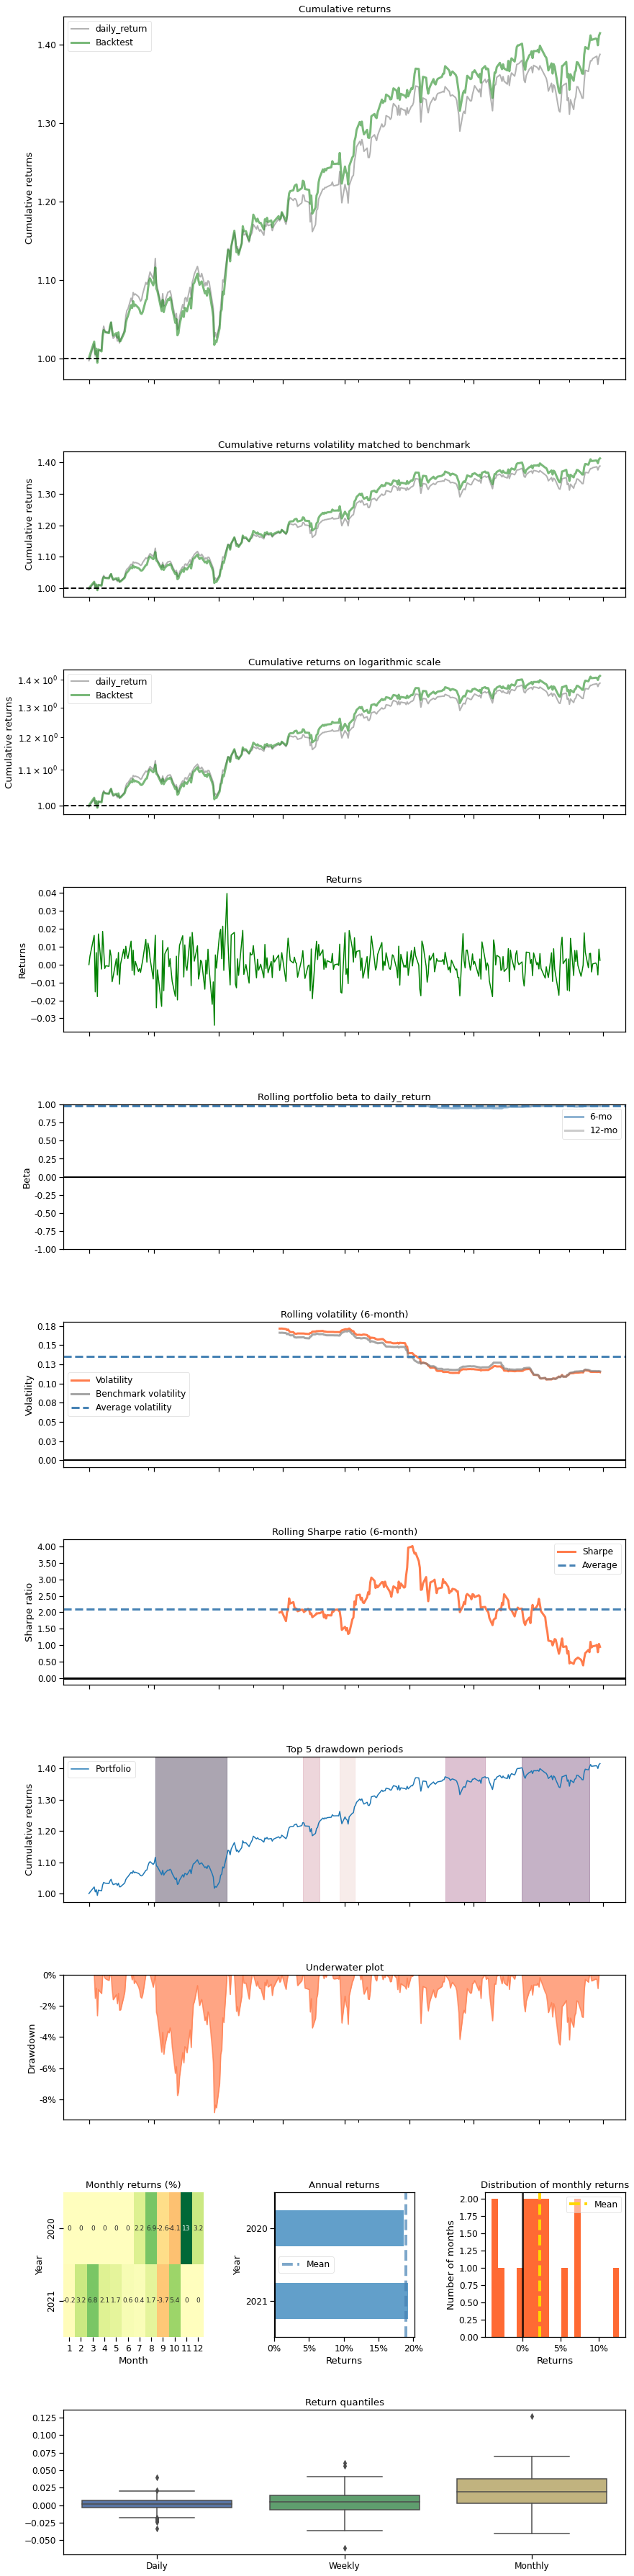

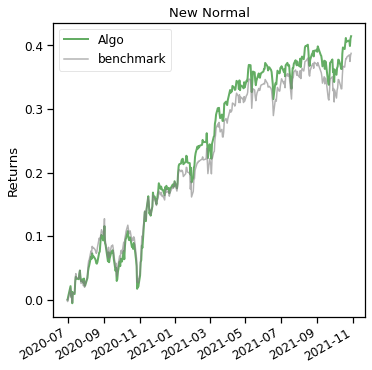

In [ ]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return.loc[0,'date'], end='2021-11-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

## Min-Variance Portfolio Allocation

In [ ]:
%pip install PyPortfolioOpt

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [ ]:
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [ ]:
df.head()

date       open       high        low      close      adjcp  \
0  2008-12-30   3.122143   3.144643   3.025714   3.081786   2.638855   
1  2008-12-30  57.000000  57.660000  56.820000  57.590000  44.154682   
2  2008-12-30  17.820000  18.129999  17.700001  18.000000  14.507502   
3  2008-12-30  40.080002  41.340000  39.810001  41.250000  30.940779   
4  2008-12-30  42.570000  43.750000  42.009998  43.660000  30.079866   

      volume   tic  day      macd    boll_ub    boll_lb     rsi_30  \
0  967601600  AAPL    1 -0.095139   3.647287   2.922999  42.673739   
1    4300800  AMGN    1  0.206630  59.373659  55.651341  50.840501   
2   11777300   AXP    1 -1.263168  23.794809  16.256191  41.524298   
3    4549700    BA    1 -0.597202  42.590111  38.593890  45.299685   
4    5060400   CAT    1  0.850860  45.671279  37.851721  49.916105   

       cci_30      dx_30  close_30_sma  close_60_sma  \
0  -80.272843  16.129793      3.246952      3.383500   
1   37.623751  17.245628     56.616000     55.998167   
2 -101.263980  33.966523     20.057333     22.604000   
3   38.696627   7.693500     40.382334     43.448167   
4   73.697581  19.456481     39.967000     39.993833   

                                            cov_list  \
0  [[0.001349448862375765, 0.00042834220439268546...   
1  [[0.001349448862375765, 0.00042834220439268546...   
2  [[0.001349448862375765, 0.00042834220439268546...   
3  [[0.001349448862375765, 0.00042834220439268546...   
4  [[0.001349448862375765, 0.00042834220439268546...   

                                         return_list  
0  tic             AAPL      AMGN       AXP      ...  
1  tic             AAPL      AMGN       AXP      ...  
2  tic             AAPL      AMGN       AXP      ...  
3  tic             AAPL      AMGN       AXP      ...  
4  tic             AAPL      AMGN       AXP      ...

In [ ]:
#calculate_portfolio_minimum_variance
portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()
    
    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value 
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
    
portfolio=portfolio.T
portfolio.columns = ['account_value']

In [ ]:
portfolio.head()

account_value
2020-07-01         1000000
2020-07-02  1005234.883501
2020-07-06  1014933.780399
2020-07-07  1014238.666671
2020-07-08  1012674.038646

In [ ]:
a2c_cumpod =(df_daily_return.daily_return+1).cumprod()-1

In [ ]:
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1

In [ ]:
dji_cumpod =(baseline_returns+1).cumprod()-1

## Plotly: DRL, Min-Variance, DJIA

In [ ]:
%pip install plotly

In [ ]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [ ]:
time_ind = pd.Series(df_daily_return.date)

In [ ]:
trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C (Portfolio Allocation)')

trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
#trace3_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG')
#trace4_portfolio = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')
#trace5_portfolio = go.Scatter(x = time_ind, y = min_cumpod, mode = 'lines', name = 'Min-Variance')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [ ]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)

fig.add_trace(trace1_portfolio)

fig.add_trace(trace2_portfolio)



fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()